# Goal

The goal of this colab is to train a CNN on the IBM-NASA dataset for crop clasification.

# Installation

This module is dedicated for the installation of required packages for the usage of this collab.

In [1]:
!pip install segmentation-models-pytorch torch torchvision torchmetrics datasets albumentations rasterio tqdm pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Imports

In [2]:
import os
import copy
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import time
import json


import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from segmentation_models_pytorch import UnetPlusPlus
from segmentation_models_pytorch.losses import FocalLoss, TverskyLoss
from torch.utils.tensorboard import SummaryWriter


import pandas as pd

from torchmetrics.classification import Accuracy, JaccardIndex
from torchmetrics.segmentation import DiceScore, MeanIoU

from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.transforms import ToTensor
from functools import lru_cache
from tqdm import tqdm

# Dataset loading
from datasets import load_dataset

# Google Drive Configuration

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Configuration

This block of code will configure all the requried global variables for the project. Some of this variables may have to be changed base on the user so make sure to check them out before executing the program.

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 14

# Trainign
EPOCHS = 50
BATCH_SIZE = 32

# Loading
NUM_WORKERS = 0

# Model params
ENCODER_NAME = "resnet34"
ENCODER_WEIGHTS = None
LEARNING_RATE = 1e-4
DECODER_ATTENTION_TYPE = "scse"
DECODER_USER_NORM = False

# Data directories
DATA_DIR = "/content/drive/MyDrive/Universidad/TFG/Implementations/nasa_ibm/"
UNET_MODEL_FOLDER  = "/content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/models/"
UNET_GRAPH_FOLDER  = "/content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/graphs/"
UNET_METRICS_FOLDER  = "/content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/metrics/"

SPLIT_DIR = DATA_DIR + "splited"

TRAINING_IMAGE_DIR = DATA_DIR + "training_chips_merged"
TRAINING_MASK_DIR = DATA_DIR + "training_chips_mask"

VALIDATION_IMAGE_DIR = DATA_DIR + "training_chips_merged"
VALIDATION_MASK_DIR = DATA_DIR + "training_chips_mask"

TEST_IMAGE_DIR = DATA_DIR + "test_chips_merged"
TEST_MASK_DIR = DATA_DIR + "test_chips_mask"

In [5]:
class HFDGeoDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, image_dir, mask_dir, transform=None, is_original_dataset = True ):
        self.dataset = hf_dataset
        self.to_tensor = ToTensor()
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        self.chip_ids = [item['text'] for item in self.dataset]

        self.image_paths = [os.path.join(image_dir, f"{chip_id}_merged.tif")
                           for chip_id in self.chip_ids]
        self.mask_paths = [os.path.join(mask_dir, f"{chip_id}.mask.tif")
                          for chip_id in self.chip_ids]


        self.use_memmap = True

    def __len__(self):
        return len(self.dataset)

    @lru_cache(maxsize=128)  # Cache recently accessed items
    def _load_image(self, image_path):
        """Load image with caching for repeated access."""
        try:
            with rasterio.open(image_path) as src:
                if self.use_memmap:
                    # Try memory-mapped reading when possible
                    image = src.read(out_shape=src.shape, masked=False)
                else:
                    image = src.read()
                return torch.from_numpy(image).type(torch.FloatTensor)
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            # Return empty tensor or handle error appropriately
            return torch.zeros((18, 224, 224), dtype=torch.float32)

    @lru_cache(maxsize=128)
    def _load_mask(self, mask_path):
        try:
            with rasterio.open(mask_path) as chip_mask:
                mask = chip_mask.read(1)
                return torch.from_numpy(mask).type(torch.LongTensor)
        except Exception as e:
            print(f"Error loading mask {mask_path}: {e}")
            return torch.zeros((224, 224), dtype=torch.long)

    def _normalize_per_band(self, image):
        normalized = np.zeros_like(image, dtype=np.float32)

        for i in range(image.shape[0]):
            band = image[i]
            band_min = band.min()
            band_max = band.max()

            if band_max > band_min:
                normalized[i] = ((band - band_min)/(band_max - band_min))
            else:
                normalized[i] = np.zeros_like(band)

        return torch.from_numpy(normalized).float()

    def __getitem__(self, idx):
        chip_id = self.dataset[idx]['text']
        image_path = self.image_paths[idx]
        mask_path  = self.mask_paths[idx]

        image = self._load_image(image_path)
        mask  = self._load_mask(mask_path)

        image = self._normalize_per_band(image)


        return image, mask





def create_datasets(dataset, image_dirs, mask_dirs, transform = None):
    # Create train and validation datasets
    train_dataset = HFDGeoDataset(
        dataset['train'],
        image_dir=image_dirs,
        mask_dir=mask_dirs,
        transform=transform
    )

    val_dataset = HFDGeoDataset(
        dataset['validation'],
        image_dir=image_dirs,
        mask_dir=mask_dirs,
        transform=transform
    )

    return train_dataset, val_dataset

def create_data_loaders(train_dataset, val_dataset, batch_size=BATCH_SIZE, ):
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=False,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
    )

    return train_loader, val_loader


def visualize_random_rgb_sample(dataset, bands=(2, 1, 0), figsize=(10, 5)):
    """
    Picks a random sample and displays specified bands as an RGB composite,
    with per-band min/max normalization for proper visibility.

    Args:
        dataset: your HFDGeoDataset instance
        bands (tuple of int): which bands to use for R, G, B
        figsize (tuple): figure size in inches
    """
    # 1) Pick a random index
    idx = random.randint(0, len(dataset) - 1)
    image, mask = dataset[idx]       # image: Tensor[18, H, W], mask: Tensor[H, W]

    # 2) Select just the three bands and convert to a HxWx3 NumPy array
    img_bands = image[list(bands), ...]            # shape = (3, H, W)
    img_np = img_bands.permute(1, 2, 0).numpy()    # shape = (H, W, 3)

    print( image )

    # 3) Per-band min/max normalization
    for c in range(3):
        band = img_np[..., c]
        mn, mx = band.min(), band.max()
        img_np[..., c] = (band - mn) / (mx - mn + 1e-6)

    # 4) Plot side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    ax1.imshow(img_np)
    ax1.set_title(f"Sample #{idx} RGB (bands {bands})")
    ax1.axis("off")

    ax2.imshow(mask.numpy(), cmap="gray")
    ax2.set_title("Mask")
    ax2.axis("off")

    plt.tight_layout()
    plt.show()

<ipython-input-5-a11c6594a13c>:57: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  normalized[i] = ((band - band_min)/(band_max - band_min))


tensor([[[0.0454, 0.0719, 0.0806,  ..., 0.0711, 0.0888, 0.1189],
         [0.0515, 0.0678, 0.0721,  ..., 0.0438, 0.0825, 0.1295],
         [0.0615, 0.0664, 0.0674,  ..., 0.0529, 0.0892, 0.0884],
         ...,
         [0.1810, 0.1749, 0.1627,  ..., 0.0802, 0.0629, 0.0918],
         [0.1747, 0.1717, 0.1670,  ..., 0.0861, 0.0810, 0.0937],
         [0.1672, 0.1539, 0.1265,  ..., 0.0806, 0.0774, 0.0808]],

        [[0.0721, 0.1100, 0.1248,  ..., 0.1014, 0.1229, 0.1524],
         [0.0798, 0.1098, 0.1182,  ..., 0.0658, 0.1055, 0.1559],
         [0.0919, 0.1082, 0.1166,  ..., 0.0731, 0.1078, 0.1103],
         ...,
         [0.2400, 0.2321, 0.2178,  ..., 0.1237, 0.1003, 0.1273],
         [0.2348, 0.2307, 0.2251,  ..., 0.1302, 0.1173, 0.1336],
         [0.2260, 0.2087, 0.1770,  ..., 0.1237, 0.1143, 0.1118]],

        [[0.0619, 0.0995, 0.1109,  ..., 0.0993, 0.1271, 0.1671],
         [0.0713, 0.0996, 0.1012,  ..., 0.0712, 0.1224, 0.1715],
         [0.0877, 0.1008, 0.0961,  ..., 0.0835, 0.1244, 0.

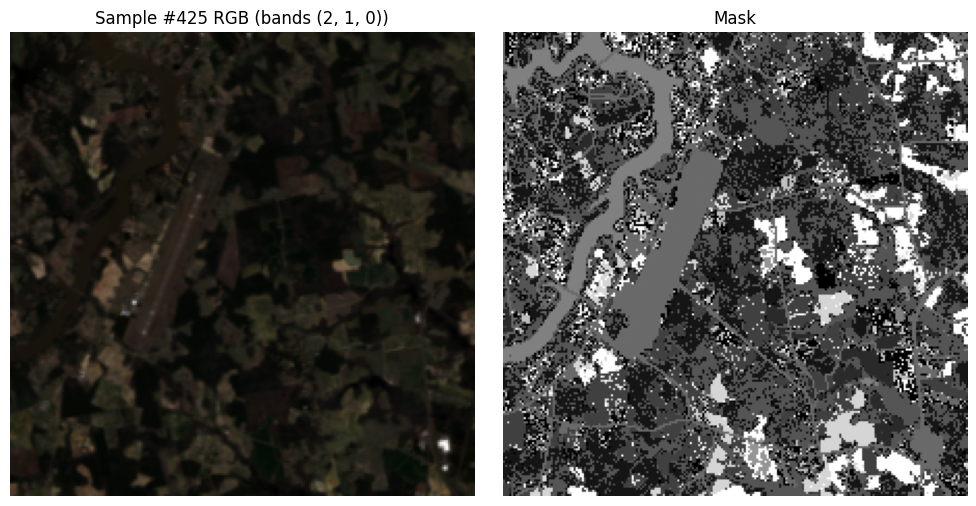

tensor([[[0.3706, 0.3166, 0.2816,  ..., 0.0454, 0.0450, 0.0440],
         [0.3318, 0.3114, 0.3053,  ..., 0.0431, 0.0421, 0.0487],
         [0.3109, 0.3242, 0.3365,  ..., 0.0445, 0.0421, 0.0506],
         ...,
         [0.0866, 0.0696, 0.0842,  ..., 0.2229, 0.2343, 0.2257],
         [0.1533, 0.1159, 0.1278,  ..., 0.2442, 0.2551, 0.2475],
         [0.1884, 0.1344, 0.1287,  ..., 0.2158, 0.2310, 0.2314]],

        [[0.3526, 0.2986, 0.2609,  ..., 0.0886, 0.0840, 0.0791],
         [0.3106, 0.2859, 0.2810,  ..., 0.0822, 0.0762, 0.0854],
         [0.2916, 0.2972, 0.3057,  ..., 0.0822, 0.0784, 0.0875],
         ...,
         [0.1168, 0.0992, 0.1158,  ..., 0.2337, 0.2429, 0.2273],
         [0.1740, 0.1366, 0.1525,  ..., 0.2464, 0.2489, 0.2330],
         [0.2150, 0.1567, 0.1514,  ..., 0.2213, 0.2266, 0.2217]],

        [[0.3433, 0.2865, 0.2480,  ..., 0.0541, 0.0547, 0.0518],
         [0.2996, 0.2709, 0.2645,  ..., 0.0509, 0.0521, 0.0579],
         [0.2799, 0.2822, 0.2874,  ..., 0.0498, 0.0478, 0.

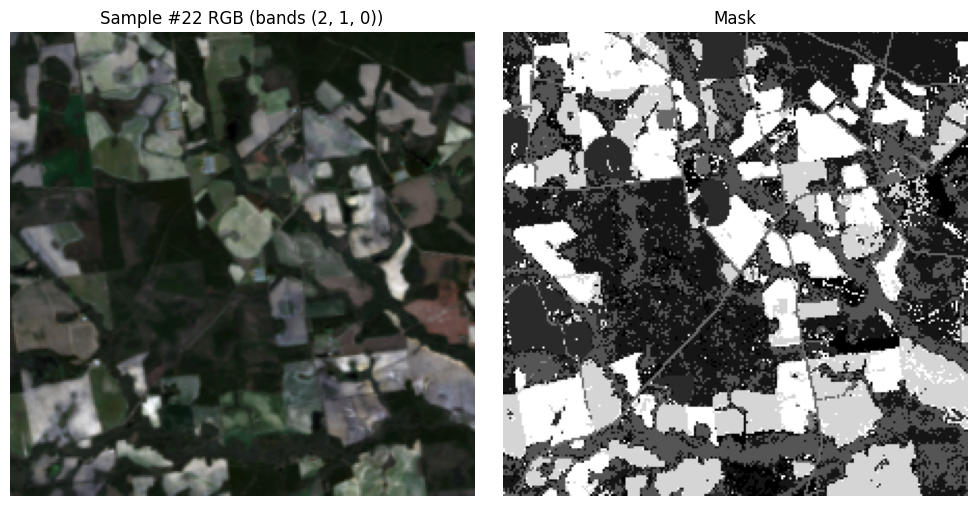

In [6]:
with open(os.path.join(SPLIT_DIR, 'dataset_splits.json')) as f:
    train_val_dataset = json.load(f)



# Create datasets
train_dataset, val_dataset = create_datasets(train_val_dataset, TRAINING_IMAGE_DIR, TRAINING_MASK_DIR)

# Create data loaders
train_loader, val_loader = create_data_loaders(train_dataset, val_dataset, batch_size=BATCH_SIZE)

visualize_random_rgb_sample(train_dataset)
visualize_random_rgb_sample(val_dataset)

In [7]:
model = UnetPlusPlus(
    encoder_name=ENCODER_NAME,
    encoder_weights=ENCODER_WEIGHTS,
    in_channels=18,
    classes=NUM_CLASSES,
    decoder_attention_type=DECODER_ATTENTION_TYPE,
    decoder_use_norm=DECODER_USER_NORM
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

focal_loss = FocalLoss(mode="multiclass", gamma=2.0)
tversky_loss =  TverskyLoss(
    mode='multiclass',
    classes=None,
    log_loss=False,
    from_logits=True,
    ignore_index=0,
    gamma=1.0
)
ce_loss = nn.CrossEntropyLoss( ignore_index = 0 );


def criterion(preds, targets):
    """
    preds: raw logits,   shape [B, C, H, W]
    targets: integer labels, shape [B, H, W]
    """
    # ensure integer dtype
    targets = targets.long()

    L_focal = focal_loss(preds, targets)

    return 1 * L_focal


scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

In [8]:
accuracy = Accuracy(task="multiclass", average="macro",  num_classes=NUM_CLASSES).to(DEVICE)
iou = JaccardIndex(task="multiclass", num_classes=NUM_CLASSES).to(DEVICE)
dice = DiceScore( num_classes=NUM_CLASSES, average="macro",   input_format="index" ).to(DEVICE)
miou = MeanIoU(num_classes=NUM_CLASSES, include_background= False,  input_format="index"  ).to(DEVICE)

Epoch 1/50:   0%|          | 0/78 [00:00<?, ?it/s]<ipython-input-5-a11c6594a13c>:57: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  normalized[i] = ((band - band_min)/(band_max - band_min))
Epoch 1/50: 100%|██████████| 78/78 [17:04<00:00, 13.14s/it]


[Epoch  0] Loss:  1.4084, Acc:   0.0823, IoU:   0.0235, Dice:  0.0260, mIoU:  0.0167


Epoch 1/50 [Val]: 100%|██████████| 20/20 [03:26<00:00, 10.32s/it]


[Epoch  0] Loss: 0.9866, Acc: 0.0928, IoU: 0.0277, Dice: 0.0372, mIoU: 0.0252


Epoch 2/50: 100%|██████████| 78/78 [10:30<00:00,  8.08s/it]


[Epoch  1] Loss:  0.9102, Acc:   0.0990, IoU:   0.0480, Dice:  0.0515, mIoU:  0.0350


Epoch 2/50 [Val]: 100%|██████████| 20/20 [02:35<00:00,  7.78s/it]


[Epoch  1] Loss: 0.8845, Acc: 0.0896, IoU: 0.0375, Dice: 0.0488, mIoU: 0.0336


Epoch 3/50: 100%|██████████| 78/78 [09:48<00:00,  7.55s/it]


[Epoch  2] Loss:  0.8693, Acc:   0.1130, IoU:   0.0516, Dice:  0.0596, mIoU:  0.0418


Epoch 3/50 [Val]: 100%|██████████| 20/20 [02:17<00:00,  6.89s/it]


[Epoch  2] Loss: 0.8550, Acc: 0.1170, IoU: 0.0565, Dice: 0.0672, mIoU: 0.0465


Epoch 4/50: 100%|██████████| 78/78 [10:17<00:00,  7.91s/it]


[Epoch  3] Loss:  0.8410, Acc:   0.1307, IoU:   0.0654, Dice:  0.0736, mIoU:  0.0517


Epoch 4/50 [Val]: 100%|██████████| 20/20 [02:12<00:00,  6.63s/it]


[Epoch  3] Loss: 0.8265, Acc: 0.1499, IoU: 0.0848, Dice: 0.0840, mIoU: 0.0592


Epoch 5/50: 100%|██████████| 78/78 [10:07<00:00,  7.79s/it]


[Epoch  4] Loss:  0.8113, Acc:   0.1792, IoU:   0.1078, Dice:  0.0944, mIoU:  0.0689


Epoch 5/50 [Val]: 100%|██████████| 20/20 [02:07<00:00,  6.38s/it]


[Epoch  4] Loss: 0.7971, Acc: 0.1944, IoU: 0.1191, Dice: 0.1036, mIoU: 0.0765


Epoch 6/50: 100%|██████████| 78/78 [10:04<00:00,  7.75s/it]


[Epoch  5] Loss:  0.7798, Acc:   0.2046, IoU:   0.1252, Dice:  0.1097, mIoU:  0.0821


Epoch 6/50 [Val]: 100%|██████████| 20/20 [02:07<00:00,  6.38s/it]


[Epoch  5] Loss: 0.7700, Acc: 0.2093, IoU: 0.1306, Dice: 0.1184, mIoU: 0.0887


Epoch 7/50: 100%|██████████| 78/78 [09:16<00:00,  7.13s/it]


[Epoch  6] Loss:  0.7502, Acc:   0.2220, IoU:   0.1356, Dice:  0.1219, mIoU:  0.0925


Epoch 7/50 [Val]: 100%|██████████| 20/20 [02:03<00:00,  6.16s/it]


[Epoch  6] Loss: 0.7470, Acc: 0.2343, IoU: 0.1448, Dice: 0.1319, mIoU: 0.0992


Epoch 8/50: 100%|██████████| 78/78 [10:00<00:00,  7.70s/it]


[Epoch  7] Loss:  0.7306, Acc:   0.2398, IoU:   0.1486, Dice:  0.1328, mIoU:  0.1013


Epoch 8/50 [Val]: 100%|██████████| 20/20 [02:10<00:00,  6.52s/it]


[Epoch  7] Loss: 0.7293, Acc: 0.2527, IoU: 0.1548, Dice: 0.1405, mIoU: 0.1063


Epoch 9/50: 100%|██████████| 78/78 [10:20<00:00,  7.95s/it]


[Epoch  8] Loss:  0.7127, Acc:   0.2593, IoU:   0.1626, Dice:  0.1431, mIoU:  0.1097


Epoch 9/50 [Val]: 100%|██████████| 20/20 [02:08<00:00,  6.44s/it]


[Epoch  8] Loss: 0.7139, Acc: 0.2671, IoU: 0.1647, Dice: 0.1479, mIoU: 0.1135


Epoch 10/50: 100%|██████████| 78/78 [09:26<00:00,  7.27s/it]


[Epoch  9] Loss:  0.6980, Acc:   0.2744, IoU:   0.1734, Dice:  0.1511, mIoU:  0.1167


Epoch 10/50 [Val]: 100%|██████████| 20/20 [01:49<00:00,  5.50s/it]


[Epoch  9] Loss: 0.7145, Acc: 0.2769, IoU: 0.1651, Dice: 0.1486, mIoU: 0.1137


Epoch 11/50: 100%|██████████| 78/78 [09:44<00:00,  7.50s/it]


[Epoch 10] Loss:  0.6859, Acc:   0.2866, IoU:   0.1828, Dice:  0.1570, mIoU:  0.1218


Epoch 11/50 [Val]: 100%|██████████| 20/20 [02:05<00:00,  6.26s/it]


[Epoch 10] Loss: 0.6940, Acc: 0.2887, IoU: 0.1823, Dice: 0.1566, mIoU: 0.1219


Epoch 12/50: 100%|██████████| 78/78 [09:07<00:00,  7.03s/it]


[Epoch 11] Loss:  0.6743, Acc:   0.2987, IoU:   0.1921, Dice:  0.1628, mIoU:  0.1274


Epoch 12/50 [Val]: 100%|██████████| 20/20 [02:08<00:00,  6.42s/it]


[Epoch 11] Loss: 0.6880, Acc: 0.2859, IoU: 0.1865, Dice: 0.1575, mIoU: 0.1235


Epoch 13/50: 100%|██████████| 78/78 [10:09<00:00,  7.82s/it]


[Epoch 12] Loss:  0.6637, Acc:   0.3099, IoU:   0.2010, Dice:  0.1683, mIoU:  0.1326


Epoch 13/50 [Val]: 100%|██████████| 20/20 [02:09<00:00,  6.48s/it]


[Epoch 12] Loss: 0.6773, Acc: 0.3081, IoU: 0.1991, Dice: 0.1689, mIoU: 0.1315


Epoch 14/50: 100%|██████████| 78/78 [10:10<00:00,  7.83s/it]


[Epoch 13] Loss:  0.6542, Acc:   0.3237, IoU:   0.2123, Dice:  0.1743, mIoU:  0.1382


Epoch 14/50 [Val]: 100%|██████████| 20/20 [02:06<00:00,  6.33s/it]


[Epoch 13] Loss: 0.6717, Acc: 0.3086, IoU: 0.2036, Dice: 0.1724, mIoU: 0.1352


Epoch 15/50: 100%|██████████| 78/78 [09:17<00:00,  7.15s/it]


[Epoch 14] Loss:  0.6444, Acc:   0.3359, IoU:   0.2222, Dice:  0.1801, mIoU:  0.1437


Epoch 15/50 [Val]: 100%|██████████| 20/20 [02:04<00:00,  6.22s/it]


[Epoch 14] Loss: 0.6685, Acc: 0.3246, IoU: 0.2141, Dice: 0.1747, mIoU: 0.1383


Epoch 16/50: 100%|██████████| 78/78 [09:56<00:00,  7.65s/it]


[Epoch 15] Loss:  0.6353, Acc:   0.3449, IoU:   0.2299, Dice:  0.1855, mIoU:  0.1486


Epoch 16/50 [Val]: 100%|██████████| 20/20 [02:00<00:00,  6.04s/it]


[Epoch 15] Loss: 0.6608, Acc: 0.3247, IoU: 0.2182, Dice: 0.1824, mIoU: 0.1438


Epoch 17/50: 100%|██████████| 78/78 [08:56<00:00,  6.88s/it]


[Epoch 16] Loss:  0.6264, Acc:   0.3543, IoU:   0.2373, Dice:  0.1903, mIoU:  0.1531


Epoch 17/50 [Val]: 100%|██████████| 20/20 [02:02<00:00,  6.15s/it]


[Epoch 16] Loss: 0.6595, Acc: 0.3343, IoU: 0.2191, Dice: 0.1828, mIoU: 0.1453


Epoch 18/50: 100%|██████████| 78/78 [09:04<00:00,  6.99s/it]


[Epoch 17] Loss:  0.6182, Acc:   0.3627, IoU:   0.2450, Dice:  0.1956, mIoU:  0.1578


Epoch 18/50 [Val]: 100%|██████████| 20/20 [02:06<00:00,  6.31s/it]


[Epoch 17] Loss: 0.6565, Acc: 0.3335, IoU: 0.2224, Dice: 0.1852, mIoU: 0.1476


Epoch 19/50: 100%|██████████| 78/78 [09:36<00:00,  7.39s/it]


[Epoch 18] Loss:  0.6133, Acc:   0.3690, IoU:   0.2505, Dice:  0.1993, mIoU:  0.1612


Epoch 19/50 [Val]: 100%|██████████| 20/20 [02:23<00:00,  7.18s/it]


[Epoch 18] Loss: 0.6559, Acc: 0.3325, IoU: 0.2241, Dice: 0.1887, mIoU: 0.1503


Epoch 20/50: 100%|██████████| 78/78 [09:14<00:00,  7.11s/it]


[Epoch 19] Loss:  0.6044, Acc:   0.3777, IoU:   0.2574, Dice:  0.2043, mIoU:  0.1658


Epoch 20/50 [Val]: 100%|██████████| 20/20 [02:05<00:00,  6.26s/it]


[Epoch 19] Loss: 0.6560, Acc: 0.3337, IoU: 0.2254, Dice: 0.1873, mIoU: 0.1487


Epoch 21/50: 100%|██████████| 78/78 [08:59<00:00,  6.92s/it]


[Epoch 20] Loss:  0.5957, Acc:   0.3864, IoU:   0.2648, Dice:  0.2092, mIoU:  0.1700


Epoch 21/50 [Val]: 100%|██████████| 20/20 [01:58<00:00,  5.94s/it]


[Epoch 20] Loss: 0.6502, Acc: 0.3424, IoU: 0.2340, Dice: 0.1925, mIoU: 0.1550


Epoch 22/50: 100%|██████████| 78/78 [08:58<00:00,  6.90s/it]


[Epoch 21] Loss:  0.5914, Acc:   0.3921, IoU:   0.2700, Dice:  0.2126, mIoU:  0.1731


Epoch 22/50 [Val]: 100%|██████████| 20/20 [02:03<00:00,  6.20s/it]


[Epoch 21] Loss: 0.7076, Acc: 0.3092, IoU: 0.2154, Dice: 0.1808, mIoU: 0.1459


Epoch 23/50: 100%|██████████| 78/78 [09:17<00:00,  7.14s/it]


[Epoch 22] Loss:  0.5899, Acc:   0.3947, IoU:   0.2723, Dice:  0.2135, mIoU:  0.1741


Epoch 23/50 [Val]: 100%|██████████| 20/20 [01:42<00:00,  5.11s/it]


[Epoch 22] Loss: 0.7675, Acc: 0.2841, IoU: 0.1853, Dice: 0.1737, mIoU: 0.1409


Epoch 24/50: 100%|██████████| 78/78 [10:25<00:00,  8.02s/it]


[Epoch 23] Loss:  0.5876, Acc:   0.3969, IoU:   0.2747, Dice:  0.2155, mIoU:  0.1761


Epoch 24/50 [Val]: 100%|██████████| 20/20 [01:30<00:00,  4.54s/it]


[Epoch 23] Loss: 0.6757, Acc: 0.3272, IoU: 0.2220, Dice: 0.1899, mIoU: 0.1536


Epoch 25/50: 100%|██████████| 78/78 [10:19<00:00,  7.95s/it]


[Epoch 24] Loss:  0.5842, Acc:   0.3995, IoU:   0.2777, Dice:  0.2171, mIoU:  0.1780


Epoch 25/50 [Val]: 100%|██████████| 20/20 [02:03<00:00,  6.16s/it]


[Epoch 24] Loss: 0.6480, Acc: 0.3605, IoU: 0.2446, Dice: 0.2034, mIoU: 0.1632


Epoch 26/50: 100%|██████████| 78/78 [10:05<00:00,  7.76s/it]


[Epoch 25] Loss:  0.5717, Acc:   0.4108, IoU:   0.2872, Dice:  0.2235, mIoU:  0.1842


Epoch 26/50 [Val]: 100%|██████████| 20/20 [02:07<00:00,  6.36s/it]


[Epoch 25] Loss: 0.6331, Acc: 0.3744, IoU: 0.2560, Dice: 0.2102, mIoU: 0.1685


Epoch 27/50: 100%|██████████| 78/78 [11:00<00:00,  8.47s/it]


[Epoch 26] Loss:  0.5608, Acc:   0.4220, IoU:   0.2972, Dice:  0.2295, mIoU:  0.1899


Epoch 27/50 [Val]: 100%|██████████| 20/20 [02:15<00:00,  6.80s/it]


[Epoch 26] Loss: 0.7035, Acc: 0.3356, IoU: 0.2263, Dice: 0.1885, mIoU: 0.1484


Epoch 28/50: 100%|██████████| 78/78 [11:57<00:00,  9.20s/it]


[Epoch 27] Loss:  0.5537, Acc:   0.4304, IoU:   0.3049, Dice:  0.2345, mIoU:  0.1944


Epoch 28/50 [Val]: 100%|██████████| 20/20 [02:28<00:00,  7.44s/it]


[Epoch 27] Loss: 0.6682, Acc: 0.3777, IoU: 0.2594, Dice: 0.2004, mIoU: 0.1589


Epoch 29/50: 100%|██████████| 78/78 [11:30<00:00,  8.85s/it]


[Epoch 28] Loss:  0.5476, Acc:   0.4713, IoU:   0.3357, Dice:  0.2379, mIoU:  0.1977


Epoch 29/50 [Val]: 100%|██████████| 20/20 [02:32<00:00,  7.61s/it]


[Epoch 28] Loss: 0.6428, Acc: 0.4095, IoU: 0.2732, Dice: 0.2106, mIoU: 0.1669


Epoch 30/50: 100%|██████████| 78/78 [11:02<00:00,  8.50s/it]


[Epoch 29] Loss:  0.5413, Acc:   0.4805, IoU:   0.3439, Dice:  0.2423, mIoU:  0.2016


Epoch 30/50 [Val]: 100%|██████████| 20/20 [02:09<00:00,  6.50s/it]


[Epoch 29] Loss: 0.6574, Acc: 0.3962, IoU: 0.2631, Dice: 0.2001, mIoU: 0.1594


Epoch 31/50: 100%|██████████| 78/78 [10:43<00:00,  8.25s/it]


[Epoch 30] Loss:  0.5321, Acc:   0.4919, IoU:   0.3545, Dice:  0.2479, mIoU:  0.2070


Epoch 31/50 [Val]: 100%|██████████| 20/20 [02:16<00:00,  6.80s/it]


[Epoch 30] Loss: 0.6549, Acc: 0.4014, IoU: 0.2693, Dice: 0.2042, mIoU: 0.1616


Epoch 32/50: 100%|██████████| 78/78 [10:26<00:00,  8.03s/it]


[Epoch 31] Loss:  0.5263, Acc:   0.5005, IoU:   0.3627, Dice:  0.2520, mIoU:  0.2107


Epoch 32/50 [Val]: 100%|██████████| 20/20 [02:07<00:00,  6.35s/it]


[Epoch 31] Loss: 0.6687, Acc: 0.4031, IoU: 0.2757, Dice: 0.2091, mIoU: 0.1661


Epoch 33/50: 100%|██████████| 78/78 [10:12<00:00,  7.85s/it]


[Epoch 32] Loss:  0.5269, Acc:   0.5022, IoU:   0.3637, Dice:  0.2527, mIoU:  0.2113


Epoch 33/50 [Val]: 100%|██████████| 20/20 [02:13<00:00,  6.68s/it]


[Epoch 32] Loss: 0.6409, Acc: 0.4039, IoU: 0.2792, Dice: 0.2140, mIoU: 0.1713


Epoch 34/50: 100%|██████████| 78/78 [09:58<00:00,  7.67s/it]


[Epoch 33] Loss:  0.5179, Acc:   0.5129, IoU:   0.3738, Dice:  0.2572, mIoU:  0.2154


Epoch 34/50 [Val]: 100%|██████████| 20/20 [02:07<00:00,  6.38s/it]


[Epoch 33] Loss: 0.6428, Acc: 0.4026, IoU: 0.2805, Dice: 0.2141, mIoU: 0.1723


Epoch 35/50: 100%|██████████| 78/78 [10:13<00:00,  7.87s/it]


[Epoch 34] Loss:  0.5081, Acc:   0.5253, IoU:   0.3853, Dice:  0.2630, mIoU:  0.2214


Epoch 35/50 [Val]: 100%|██████████| 20/20 [02:11<00:00,  6.60s/it]


[Epoch 34] Loss: 0.6451, Acc: 0.4130, IoU: 0.2883, Dice: 0.2164, mIoU: 0.1745


Epoch 36/50: 100%|██████████| 78/78 [10:20<00:00,  7.95s/it]


[Epoch 35] Loss:  0.5010, Acc:   0.5356, IoU:   0.3951, Dice:  0.2681, mIoU:  0.2262


Epoch 36/50 [Val]: 100%|██████████| 20/20 [02:07<00:00,  6.38s/it]


[Epoch 35] Loss: 0.6358, Acc: 0.4162, IoU: 0.2913, Dice: 0.2212, mIoU: 0.1790


Epoch 37/50: 100%|██████████| 78/78 [09:57<00:00,  7.66s/it]


[Epoch 36] Loss:  0.4971, Acc:   0.5415, IoU:   0.4008, Dice:  0.2709, mIoU:  0.2289


Epoch 37/50 [Val]: 100%|██████████| 20/20 [02:10<00:00,  6.50s/it]


[Epoch 36] Loss: 0.6443, Acc: 0.4084, IoU: 0.2878, Dice: 0.2209, mIoU: 0.1798


Epoch 38/50: 100%|██████████| 78/78 [09:24<00:00,  7.24s/it]


[Epoch 37] Loss:  0.4962, Acc:   0.5444, IoU:   0.4037, Dice:  0.2721, mIoU:  0.2302


Epoch 38/50 [Val]: 100%|██████████| 20/20 [02:06<00:00,  6.33s/it]


[Epoch 37] Loss: 0.6498, Acc: 0.4139, IoU: 0.2895, Dice: 0.2215, mIoU: 0.1795


Epoch 39/50: 100%|██████████| 78/78 [09:57<00:00,  7.66s/it]


[Epoch 38] Loss:  0.4980, Acc:   0.5427, IoU:   0.4014, Dice:  0.2717, mIoU:  0.2293


Epoch 39/50 [Val]: 100%|██████████| 20/20 [02:12<00:00,  6.60s/it]


[Epoch 38] Loss: 0.6325, Acc: 0.4069, IoU: 0.2826, Dice: 0.2142, mIoU: 0.1780


Epoch 40/50: 100%|██████████| 78/78 [09:21<00:00,  7.19s/it]


[Epoch 39] Loss:  0.4904, Acc:   0.5503, IoU:   0.4095, Dice:  0.2755, mIoU:  0.2336


Epoch 40/50 [Val]: 100%|██████████| 20/20 [02:09<00:00,  6.49s/it]


[Epoch 39] Loss: 0.6232, Acc: 0.4264, IoU: 0.2950, Dice: 0.2212, mIoU: 0.1808


Epoch 41/50: 100%|██████████| 78/78 [09:20<00:00,  7.19s/it]


[Epoch 40] Loss:  0.4833, Acc:   0.5593, IoU:   0.4186, Dice:  0.2799, mIoU:  0.2382


Epoch 41/50 [Val]: 100%|██████████| 20/20 [02:10<00:00,  6.54s/it]


[Epoch 40] Loss: 0.6293, Acc: 0.4319, IoU: 0.2953, Dice: 0.2224, mIoU: 0.1810


Epoch 42/50: 100%|██████████| 78/78 [10:15<00:00,  7.89s/it]


[Epoch 41] Loss:  0.4770, Acc:   0.5682, IoU:   0.4271, Dice:  0.2842, mIoU:  0.2422


Epoch 42/50 [Val]: 100%|██████████| 20/20 [02:08<00:00,  6.43s/it]


[Epoch 41] Loss: 0.6309, Acc: 0.4296, IoU: 0.2938, Dice: 0.2226, mIoU: 0.1811


Epoch 43/50: 100%|██████████| 78/78 [10:00<00:00,  7.69s/it]


[Epoch 42] Loss:  0.4729, Acc:   0.5739, IoU:   0.4326, Dice:  0.2872, mIoU:  0.2454


Epoch 43/50 [Val]: 100%|██████████| 20/20 [02:06<00:00,  6.33s/it]


[Epoch 42] Loss: 0.6313, Acc: 0.4215, IoU: 0.2912, Dice: 0.2215, mIoU: 0.1799


Epoch 44/50: 100%|██████████| 78/78 [10:14<00:00,  7.87s/it]


[Epoch 43] Loss:  0.4712, Acc:   0.5766, IoU:   0.4350, Dice:  0.2887, mIoU:  0.2466


Epoch 44/50 [Val]: 100%|██████████| 20/20 [02:18<00:00,  6.91s/it]


[Epoch 43] Loss: 0.6373, Acc: 0.4042, IoU: 0.2821, Dice: 0.2190, mIoU: 0.1778


Epoch 45/50: 100%|██████████| 78/78 [09:57<00:00,  7.66s/it]


[Epoch 44] Loss:  0.4710, Acc:   0.5770, IoU:   0.4352, Dice:  0.2890, mIoU:  0.2467


Epoch 45/50 [Val]: 100%|██████████| 20/20 [02:05<00:00,  6.28s/it]


[Epoch 44] Loss: 0.6445, Acc: 0.4031, IoU: 0.2813, Dice: 0.2205, mIoU: 0.1791


Epoch 46/50: 100%|██████████| 78/78 [09:59<00:00,  7.68s/it]


[Epoch 45] Loss:  0.4706, Acc:   0.5778, IoU:   0.4364, Dice:  0.2894, mIoU:  0.2471


Epoch 46/50 [Val]: 100%|██████████| 20/20 [02:03<00:00,  6.16s/it]


[Epoch 45] Loss: 0.6423, Acc: 0.4226, IoU: 0.2914, Dice: 0.2236, mIoU: 0.1816


Epoch 47/50: 100%|██████████| 78/78 [09:07<00:00,  7.02s/it]


[Epoch 46] Loss:  0.4701, Acc:   0.5797, IoU:   0.4377, Dice:  0.2898, mIoU:  0.2477


Epoch 47/50 [Val]: 100%|██████████| 20/20 [02:07<00:00,  6.38s/it]


[Epoch 46] Loss: 0.6290, Acc: 0.4344, IoU: 0.3002, Dice: 0.2260, mIoU: 0.1828


Epoch 48/50: 100%|██████████| 78/78 [09:18<00:00,  7.17s/it]


[Epoch 47] Loss:  0.4654, Acc:   0.5847, IoU:   0.4435, Dice:  0.2926, mIoU:  0.2509


Epoch 48/50 [Val]: 100%|██████████| 20/20 [02:06<00:00,  6.34s/it]


[Epoch 47] Loss: 0.6309, Acc: 0.4379, IoU: 0.3013, Dice: 0.2263, mIoU: 0.1822


Epoch 49/50: 100%|██████████| 78/78 [09:49<00:00,  7.56s/it]


[Epoch 48] Loss:  0.4620, Acc:   0.5899, IoU:   0.4486, Dice:  0.2951, mIoU:  0.2534


Epoch 49/50 [Val]: 100%|██████████| 20/20 [02:06<00:00,  6.31s/it]


[Epoch 48] Loss: 0.6326, Acc: 0.4369, IoU: 0.3000, Dice: 0.2260, mIoU: 0.1819


Epoch 50/50: 100%|██████████| 78/78 [10:27<00:00,  8.04s/it]


[Epoch 49] Loss:  0.4590, Acc:   0.5943, IoU:   0.4529, Dice:  0.2973, mIoU:  0.2555


Epoch 50/50 [Val]: 100%|██████████| 20/20 [02:08<00:00,  6.44s/it]


[Epoch 49] Loss: 0.6338, Acc: 0.4353, IoU: 0.2992, Dice: 0.2260, mIoU: 0.1820


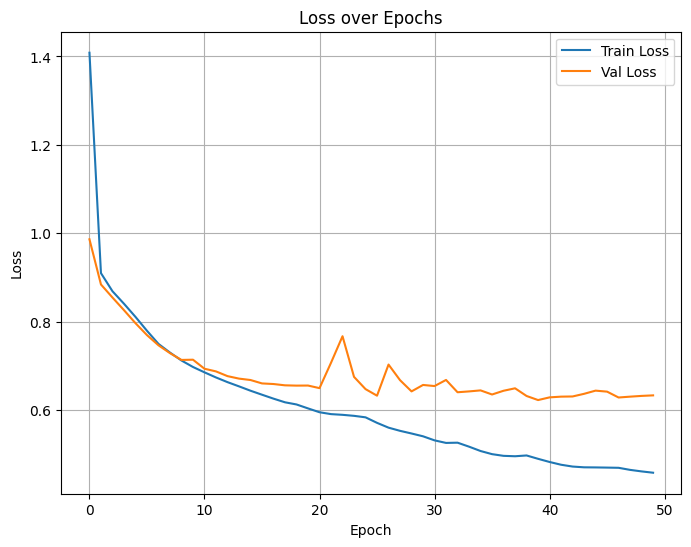

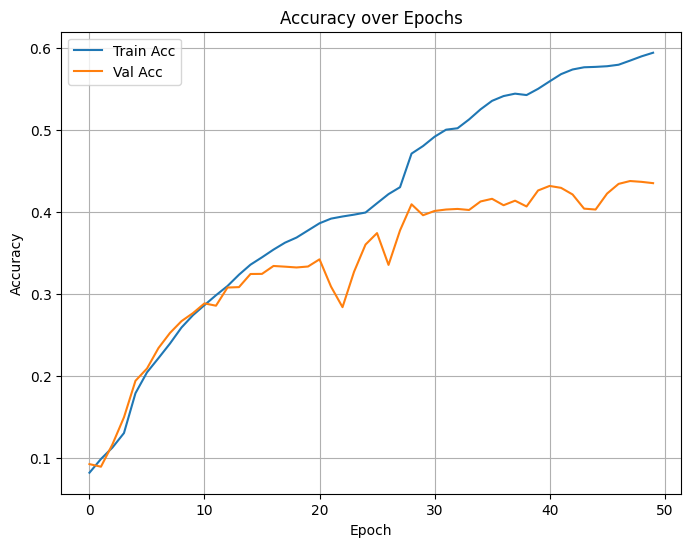

In [9]:


writer = SummaryWriter(log_dir="runs/experiment1")

labels = {
      0: "No Data",
      1: "Natural Vegetation",
      2: "Forest",
      3: "Corn",
      4: "Soybeans",
      5: "Wetlands",
      6: "Developed Barren",
      7: "Open Water",
      8: "Winter Wheat",
      9: "Alfalfa",
      10: "Fallow Idle Cropland",
      11: "Cotton",
      12: "Sorghum",
      13: "Other"
  }

train_losses, train_accs, train_ious, train_mious, train_dices = [], [], [], [], []
val_losses,   val_accs,   val_ious,   val_mious,  val_dices = [], [], [], [], []
best_val_acc = 0.0
best_epoch     = 0
best_model_wts = None

for epoch in range(EPOCHS):
    model.train()
    train_loss_sum = train_acc_sum = train_iou_sum = train_dice_sum = train_miou_sum = 0.0
    accuracy.reset(); iou.reset(); dice.reset(); miou.reset()

    ### ——— TRAIN ———
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, masks = images.to(DEVICE), masks.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, dim=1)

        accuracy.update(preds, masks)
        iou      .update(preds, masks)
        dice     .update(preds, masks)
        miou     .update(preds, masks)

        train_loss_sum  += loss.item()

    # Average metrics
    train_losses.append(train_loss_sum / len(train_loader))
    train_accs  .append(accuracy.compute().item())
    train_ious  .append(iou.compute().item())
    train_dices .append(dice.compute().item())
    train_mious .append(miou.compute().item())

    writer.add_scalar('Loss/train', train_losses[-1], epoch)
    writer.add_scalar('Accuracy/train', train_accs[-1], epoch)
    writer.add_scalar('IoU/train', train_ious[-1], epoch)
    writer.add_scalar('Dice/train', train_dices[-1], epoch)
    writer.add_scalar('mIoU/train', train_mious[-1], epoch)


    tqdm.write(
        f"[Epoch {epoch:>2d}] "
        f"Loss:  {train_losses[-1]:.4f}, "
        f"Acc:   {train_accs[-1]:.4f}, "
        f"IoU:   {train_ious[-1]:.4f}, "
        f"Dice:  {train_dices[-1]:.4f}, "
        f"mIoU:  {train_mious[-1]:.4f}"
    )

    ### ——— VALIDATION ———
    model.eval()
    val_loss_sum = val_acc_sum = val_iou_sum = val_dice_sum = val_miou_sum = 0.0
    accuracy.reset(); iou.reset(); dice.reset(); miou.reset()

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, masks)

            preds = torch.argmax(outputs, dim=1)

            accuracy.update(preds, masks)
            iou      .update(preds, masks)
            dice     .update(preds, masks)
            miou     .update(preds, masks)

            val_loss_sum  += loss.item()

    # Average metrics
    val_acc = accuracy.compute().item()
    val_losses.append(val_loss_sum / len(val_loader))
    val_accs  .append(val_acc)
    val_ious  .append(iou.compute().item())
    val_dices .append(dice.compute().item())
    val_mious .append(miou.compute().item())

    # Log to TensorBoard
    writer.add_scalar('Loss/val', val_losses[-1], epoch)
    writer.add_scalar('Accuracy/val', val_accs[-1], epoch)
    writer.add_scalar('IoU/val', val_ious[-1], epoch)
    writer.add_scalar('Dice/val', val_dices[-1], epoch)
    writer.add_scalar('mIoU/val', val_mious[-1], epoch)

    tqdm.write(
        f"[Epoch {epoch:>2d}] "
        f"Loss: {val_losses[-1]:.4f}, "
        f"Acc: {val_accs[-1]:.4f}, "
        f"IoU: {val_ious[-1]:.4f}, "
        f"Dice: {val_dices[-1]:.4f}, "
        f"mIoU: {val_mious[-1]:.4f}"
    )

    # Scheduler step on validation loss
    scheduler.step(val_losses[-1])

    if val_acc > best_val_acc:
        best_val_acc   = val_acc
        best_epoch     = epoch + 1
        best_model_wts = copy.deepcopy(model.state_dict())


model.load_state_dict(best_model_wts)


# After training, plot metrics separately
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses,   label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(train_accs,  label='Train Acc')
plt.plot(val_accs,    label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Close TensorBoard writer
writer.close()


Saved Loss plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/graphs/unet++_resnet34_None_32bs_50ep_lr1e-04_loss_20250516-211211_normalized_trevesky.png


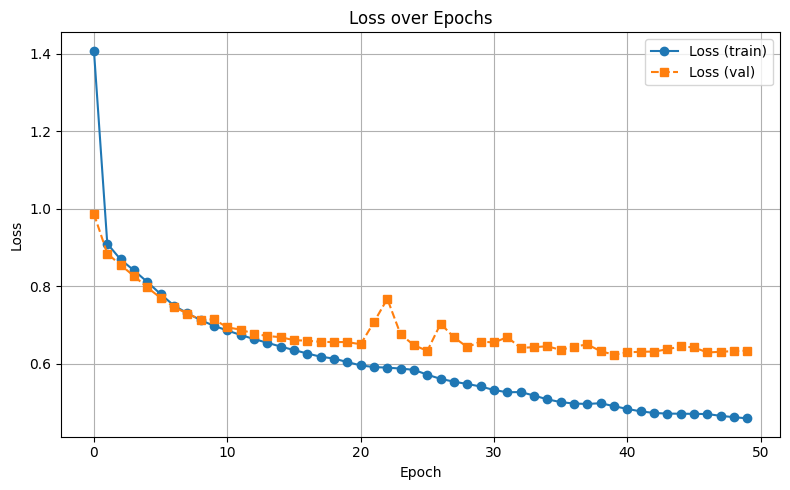

Saved Accuracy plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/graphs/unet++_resnet34_None_32bs_50ep_lr1e-04_accuracy_20250516-211211_normalized_trevesky.png


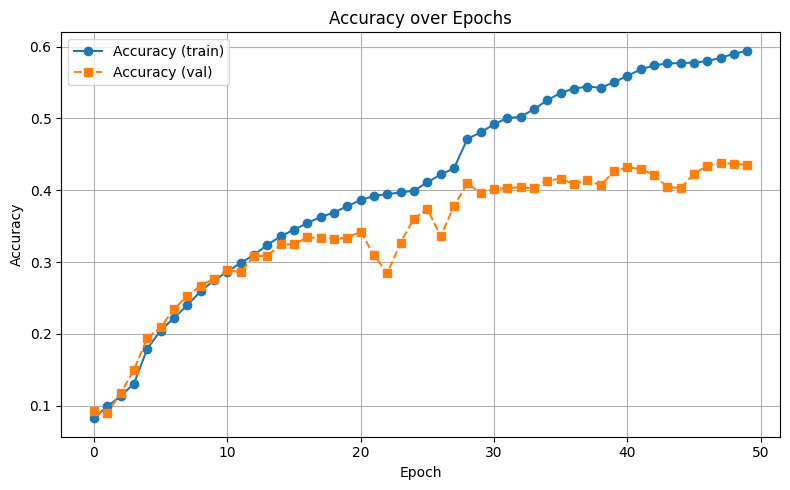

Saved Iou plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/graphs/unet++_resnet34_None_32bs_50ep_lr1e-04_iou_20250516-211211_normalized_trevesky.png


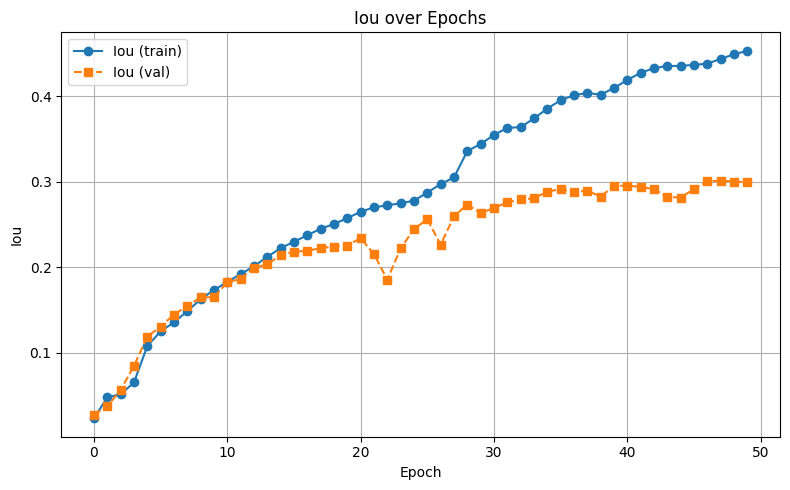

Saved Dice plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/graphs/unet++_resnet34_None_32bs_50ep_lr1e-04_dice_20250516-211211_normalized_trevesky.png


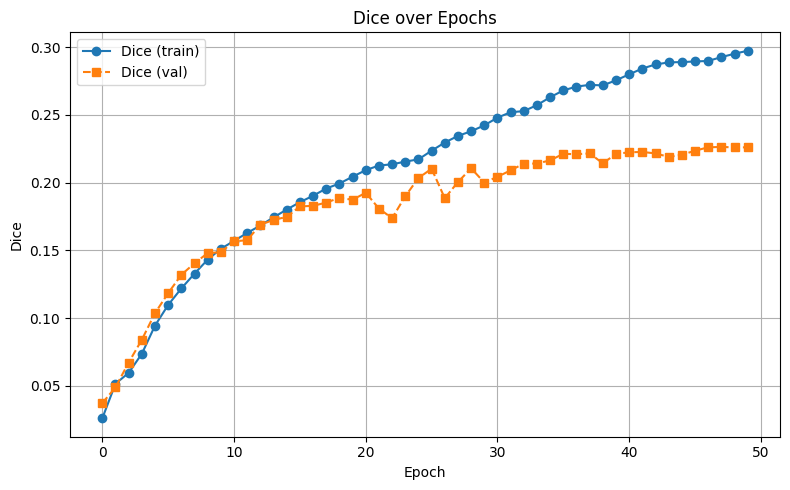

Saved Miou plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/graphs/unet++_resnet34_None_32bs_50ep_lr1e-04_miou_20250516-211211_normalized_trevesky.png


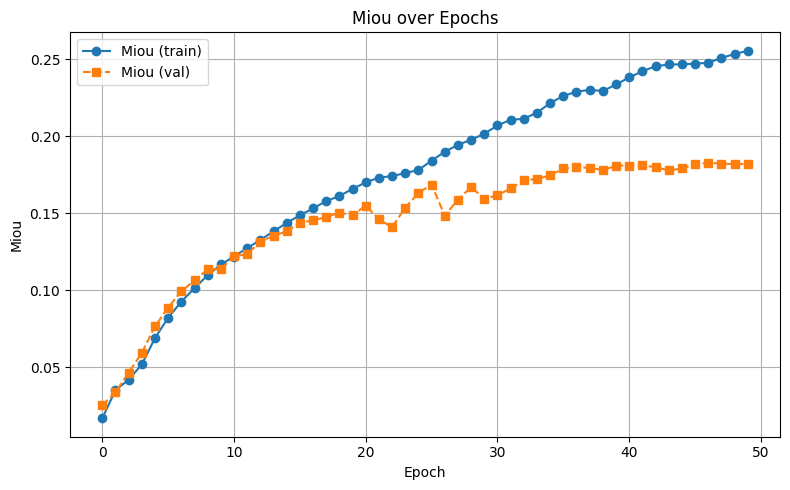

In [10]:
timestamp = time.strftime("%Y%m%d-%H%M%S")

all_metrics = {
    'loss':  (train_losses, val_losses),
    'accuracy': (train_accs, val_accs),
    'iou':    (train_ious, val_ious),
    'dice':   (train_dices, val_dices),
    'miou':   (train_mious, val_mious),
}

for metric_name, (train_vals, val_vals) in all_metrics.items():
    plt.figure(figsize=(8, 5))
    plt.plot(train_vals, marker='o', linestyle='-', label=f'{metric_name.title()} (train)')
    plt.plot(val_vals,   marker='s', linestyle='--', label=f'{metric_name.title()} (val)')
    plt.title(f'{metric_name.title()} over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name.title())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # build a descriptive filename
    filename = (
        f"unet++_{ENCODER_NAME}_{ENCODER_WEIGHTS}_"
        f"{BATCH_SIZE}bs_{EPOCHS}ep_lr{LEARNING_RATE:.0e}_"
        f"{metric_name}_{timestamp}_normalized_trevesky.png"
    )
    save_path = os.path.join(UNET_GRAPH_FOLDER, filename)

    # save and show
    plt.savefig(save_path, dpi=300)
    print(f"Saved {metric_name.title()} plot to: {save_path}")
    plt.show()

In [11]:

os.makedirs(UNET_MODEL_FOLDER, exist_ok=True)

model_filename = (
    f"unet++_{ENCODER_NAME}_{ENCODER_WEIGHTS}_"
    f"{BATCH_SIZE}bs_{EPOCHS}ep_"
    f"lr{LEARNING_RATE:.0e}_normalized_trevesky.pth"
)

model_path = os.path.join(UNET_MODEL_FOLDER, model_filename)


torch.save(model.state_dict(), model_path)
print(f"Saved model checkpoint to: {model_path}")


Saved model checkpoint to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/models/unet++_resnet34_None_32bs_50ep_lr1e-04_normalized_trevesky.pth


In [12]:
os.makedirs(UNET_METRICS_FOLDER, exist_ok=True)

# Build a DataFrame with both train & val metrics
metrics_df = pd.DataFrame({
    'Epoch':        list(range(1, len(train_losses) + 1)),
    'train_Loss':   train_losses,
    'train_Acc':    train_accs,
    'train_IoU':    train_ious,
    'train_Dice':   train_dices,
    'train_mIoU':   train_mious,
    'val_Loss':     val_losses,
    'val_Acc':      val_accs,
    'val_IoU':      val_ious,
    'val_Dice':     val_dices,
    'val_mIoU':     val_mious,
})

# Descriptive filename using your hyper-params
csv_filename = (
    f"unet++_{ENCODER_NAME}_{ENCODER_WEIGHTS}_"
    f"{BATCH_SIZE}bs_{EPOCHS}ep_lr{LEARNING_RATE:.0e}_normalized_trevesky_metrics.csv"
)
csv_path = os.path.join(UNET_METRICS_FOLDER, csv_filename)

# Save!
metrics_df.to_csv(csv_path, index=False)
print(f"Saved all train/val metrics to: {csv_path}")


Saved all train/val metrics to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/metrics/unet++_resnet34_None_32bs_50ep_lr1e-04_normalized_trevesky_metrics.csv
